# Set-up

In [1]:
import os
import torch
import numpy as np

from RBPNet import RBPNet
from losses import rbpnet_loss
from metrics import rbpnet_metrics
from module import Module
from dataload import DataloaderWrapper

import seqpro as sp
import seqdata as sd
from eugene import preprocess as pp

In [2]:
# Paths
data_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/training/2023_12_27/HepG2/U2AF2/"
log_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/models/2023_12_28/RBNet/rbpnet_chr19_U2AF2/v5/"

# Data

In [3]:
# Data
train_sdata = sd.open_zarr(os.path.join(data_dir, 'train.zarr')).load()
valid_sdata = sd.open_zarr(os.path.join(data_dir, 'valid.zarr')).load()

# Model

In [4]:
# Model
arch = RBPNet()

In [5]:
# LightningModule
module = Module(
    arch=arch,
    input_variables=["seq"],
    output_variables=["eCLIP_profile", "signal_profile", "control_profile", "mixing_coefficient"],
    target_variables=["signal", "control"],
    loss_fxn=rbpnet_loss,
    metrics_fxn=rbpnet_metrics
)

# Training data

In [6]:
# Training transforms
def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return x

def cov_dtype(x):
    return tuple(arr.astype('f4') for arr in x)

def jitter(x):
    return sp.jitter(*x, max_jitter=32, length_axis=-1, jitter_axes=0)

def to_tensor(x):
    return tuple(torch.tensor(arr, dtype=torch.float32) for arr in x)

# Get the train dataloader
train_dl = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=['_sequence'],
    variables=['seq', 'control', 'signal'],
    num_workers=0,
    prefetch_factor=None,
    batch_size=128,
    transforms={
        ('seq', 'control', 'signal'): jitter,
        'seq': seq_trans,
        ('control', 'signal'): cov_dtype,
        ('control', 'seq', 'signal'): to_tensor,
    },
    return_tuples=False,
    shuffle=True,
)
train_dl = DataloaderWrapper(train_dl, batch_per_epoch=1000)

In [7]:
# Test out batch
inputs = next(iter(train_dl))
inputs["seq"].shape, inputs["control"].shape, inputs["signal"].shape

(torch.Size([128, 4, 300]), torch.Size([128, 300]), torch.Size([128, 300]))

In [8]:
# Predict a batch
outputs = arch(inputs["seq"])
outputs_dict = {"eCLIP_profile": outputs[0], "control_profile": outputs[2]}
outputs[0].shape, outputs[1].shape

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


(torch.Size([128, 300]), torch.Size([128, 300]))

In [9]:
rbpnet_loss(
    outputs=outputs_dict,
    targets=inputs
)["loss"].mean()

tensor(2916.9089, grad_fn=<MeanBackward0>)

In [10]:
rbpnet_metrics(
    outputs=outputs_dict,
    targets=inputs
)["eCLIP_profile_pearson"].mean()

tensor(-0.0026, grad_fn=<MeanBackward0>)

In [12]:
# Functions
def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    x = x[..., 32:-32]
    return x

def cov_trans(x):
    x = x[..., 32:-32]
    return torch.as_tensor(x.astype('f4'))

valid_dl = sd.get_torch_dataloader(
    valid_sdata,
    sample_dims=['_sequence'],
    variables=['seq', 'control', 'signal'],
    num_workers=0,
    prefetch_factor=None,
    batch_size=128,
    transforms={
        'seq': seq_trans,
        'control': cov_trans,
        'signal': cov_trans,
    },
    return_tuples=False,
    shuffle=False,
)

In [13]:
# Test a batch
batch = next(iter(valid_dl))
batch["seq"].shape, batch["control"].shape, batch["signal"].shape

(torch.Size([128, 4, 300]), torch.Size([128, 300]), torch.Size([128, 300]))

# Training

In [14]:
# Logger
from pytorch_lightning.loggers import CSVLogger
logger = CSVLogger(save_dir=log_dir, name="", version="")

In [15]:
# Set-up callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(
        logger.save_dir, 
        logger.name, 
        logger.version, 
        "checkpoints"
    ),
    save_top_k=5,
    monitor="val_loss_epoch",
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=10,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
callbacks.append(LearningRateMonitor())
callbacks

In [16]:
# Trainer
from pytorch_lightning import Trainer
trainer = Trainer(
    max_epochs=100,
    logger=logger,
    devices="auto",
    accelerator="auto",
    callbacks=callbacks,
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
# Fit
trainer.fit(
    module, 
    train_dataloaders=train_dl, 
    val_dataloaders=valid_dl,
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A30') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | arch | RBPNet | 899 K 
--------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3

Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## DONE!

---

# Scratch

## Test predict

In [41]:
from metrics import pearson_corr

In [18]:
test_sdata = sd.open_zarr(os.path.join(data_dir, 'test.zarr')).load()

In [23]:
X = sp.ohe(valid_sdata["seq"].values[..., 32:-32], alphabet=sp.alphabets.DNA).transpose(0, 2, 1)

In [30]:
from tqdm import tqdm
def predict(model, x, batch_size=128, verbose=True):
    with torch.no_grad():
        device = model.device
        model.eval()
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x.astype(np.float32))
        outs = []
        for _, i in tqdm(
            enumerate(range(0, len(x), batch_size)),
            desc="Predicting on batches",
            total=len(x) // batch_size,
            disable=not verbose,
        ):
            batch = x[i : i + batch_size].to(device)
            out = model.arch(batch)[0].detach().cpu()
            outs.append(out)
        return torch.cat(outs)

In [34]:
y_pred = predict(module, X)
y_pred.shape


Predicting on batches:  94%|█████████▍| 677/718 [00:03<00:00, 209.50it/s]
Predicting on batches: 719it [00:03, 208.02it/s]                         


torch.Size([91955, 300])

In [35]:
y_clip = torch.tensor(valid_sdata["signal"].values[..., 32:-32].astype("float32"), dtype=torch.float32)
y_clip.shape

torch.Size([91955, 300])

In [36]:
# sum along sequence axis (to get total counts)
y_total = torch.sum(y_clip, axis=1)
y_total = y_total.unsqueeze(1)
y_total.shape

torch.Size([91955, 1])

In [37]:
# compute softmax of logits along sequence axis
probs = torch.nn.functional.softmax(y_pred, dim=1)

In [39]:
# return expected counts, i.e. probs * total_counts
expected_counts = probs * y_total

In [72]:
pearsons = pearson_corr(expected_counts, y_clip).detach().numpy()
pearsons.mean()

0.48304167

In [62]:
ordered_inds = np.argsort(pearsons)[::-1]

In [63]:
pearsons[ordered_inds[:5]]

array([0.97823644, 0.9773787 , 0.9772054 , 0.9770811 , 0.97644335],
      dtype=float32)

In [75]:
ordered_inds[:100]

array([72460, 72458, 72459, 72457, 72456, 72455, 72461, 72462, 52244,
       52243, 52245, 72454, 72453, 36955, 36956, 38004, 38003, 72452,
       36957, 38005, 64671, 64670, 52241, 14559, 52242, 19647, 64668,
       46046,  9400, 19645, 64667, 64666, 64669, 64665, 64663, 64672,
       64664, 46004, 42907, 42747, 14558, 38006, 38007, 70531, 52240,
       45850, 22424, 70530, 45853, 45852, 46003, 89942, 89961, 90019,
       90020, 89943, 89962, 42908, 42748, 45854, 89944, 89963, 90021,
       22425,  2446, 45851, 14557, 45855, 70529, 42909, 42749, 22423,
       45856, 42910, 42750, 45849, 85671, 70528, 70527, 21138,  2444,
       38700, 21139,  2445, 46331, 90563, 20788, 90560, 46332, 85581,
       90562, 84970, 70526, 42751, 42911, 48936, 90561, 46002, 84969,
       35604])

In [46]:
import matplotlib.pyplot as plt

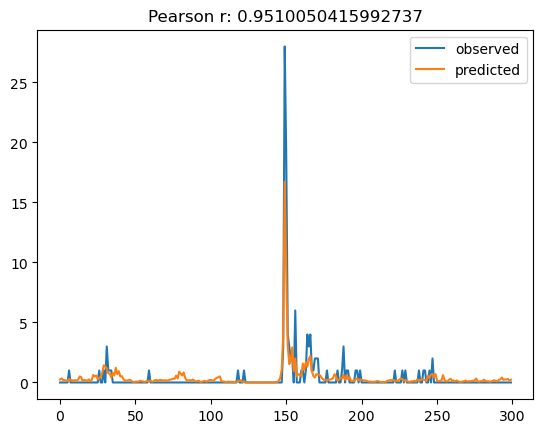

In [77]:
seq_num = 2444
plt.title(f"Pearson r: {pearsons[seq_num]}")
plt.plot(y_clip[seq_num].detach().numpy(), label="observed")
plt.plot(expected_counts[seq_num].detach().numpy(), label="predicted")
plt.legend()